<a href="https://www.kaggle.com/code/lillynguyen0510/amazon-reviews-classification-4-models?scriptVersionId=183466101" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-food-reviews-balanced-dataset/Amazon-Food-Reviews.csv


In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re
import seaborn as snsb
import matplotlib.pyplot as plt

2024-06-14 13:03:38.511248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 13:03:38.511375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 13:03:38.627861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the dataset
import pandas as pd

df = pd.read_csv('/kaggle/input/amazon-food-reviews-balanced-dataset/Amazon-Food-Reviews.csv')

df.head(5)

,Score,Summary,Text
0,1,"Great product, terrible price",Do not buy at this price! There are a dozen r...
1,1,Not impressed at ALL,"This product was not HORRIBLE, but I feel chea..."
2,1,Don't order from Amazon!,My dog loves this food and when I saw it here ...
3,1,"Maybe good cracker, but package was damaged","This may be a good cracker, but I had to retur..."
4,1,"Great rice, price is such a rip-off","It is a great product, however, who would spen..."


In [3]:
# Combine Summary and Text into 1 column 
df['Total reviews'] = df['Summary'] + ". " + df['Text']

# Drop unnecessary columns
df = df.reindex(columns=['Total reviews', 'Score'])

df.head(5)

,Total reviews,Score
0,"Great product, terrible price. Do not buy at t...",1
1,Not impressed at ALL. This product was not HOR...,1
2,Don't order from Amazon!. My dog loves this fo...,1
3,"Maybe good cracker, but package was damaged. T...",1
4,"Great rice, price is such a rip-off. It is a g...",1


In [4]:
# Make sure all entries in the column are strings
df['Total reviews'] = df['Total reviews'].astype(str)

# Remove html line break tags
df['Total reviews'] = df['Total reviews'].replace(to_replace=r'<br\s*/?>*', value=' ', regex=True)

In [5]:
# Convert columns to list
reviews = df['Total reviews'].tolist()
scores = df['Score'].tolist()

# Check the dimension
print(df.shape[0])
print(len(reviews))
print(len(scores))

241071
241071
241071


In [6]:
# Word tokenization

from nltk import word_tokenize

reviews_tokenized = [] # List to store valid tokenized reviews

scores_final = [] # List to store corresponding final score labels

print('Tokenizing reviews...')

for i in range(len(reviews)):
    
    try:
        tokens = word_tokenize(reviews[i].lower())
        
        if (len(tokens) > 1): # Check for reviews that are empty or consist of 1 word
            
            reviews_tokenized.append(tokens)
            
            scores_final.append(scores[i])
    except:
        pass

print('Done!')

# Check length of data after tokenization

print("Total reviews:",len(reviews_tokenized))
print("Total score labels:",len(scores_final),"\n")

# Print the first element of reviews_tokenized

print(reviews_tokenized[0])

Tokenizing reviews...
Done!
Total reviews: 241044
Total score labels: 241044 

['great', 'product', ',', 'terrible', 'price', '.', 'do', 'not', 'buy', 'at', 'this', 'price', '!', 'there', 'are', 'a', 'dozen', 'retailers', ',', 'on', 'line', 'and', 'brick', 'and', 'mortar', ',', 'who', 'sell', 'torani', 'syrups', 'for', 'much', 'less', '.', 'what', 'a', 'rip-off', '!']


In [7]:
from string import punctuation
from nltk.corpus import stopwords
import re

# Further word cleaning after tokenization

stopwords_english = stopwords.words('english')

punctuation_list = list(punctuation)

# Create another copy of reviews_tokenized for further preprocessing and experiment without affecting the original one

reviews_preprocessed = reviews_tokenized.copy()

print("Tokenising reviews...")

for i in range(len(reviews_tokenized)):
    
    new_tokens = []
    
    for word in reviews_tokenized[i]:
        
        if (word not in punctuation_list) and (word not in stopwords_english): # Remove punctuation and stop words
            
            word = word.replace("-", "")  # Remove hyphens from words
            
            word = word.replace(".", "") # Remove dots from words to normalise abbreviations
            
            regex_check = re.match(f'[a-z]+', word) # Select only tokens that consist of letters from a to z
            
            if regex_check != None:
                
                if regex_check.group() == word:
                    
                    new_tokens.append(word)
                    
    reviews_preprocessed[i] = new_tokens

print('Done!')
    
# Check if pre-processing led to any empty reviews

for i in range(len(reviews_preprocessed)):
    
    if len(reviews_preprocessed[i]) == 0:
        
        print("Review",i,"is empty!")
        
# Print the first element of reviews_preprocessed
        
print(reviews_preprocessed[0])

Tokenising reviews...
Done!
['great', 'product', 'terrible', 'price', 'buy', 'price', 'dozen', 'retailers', 'line', 'brick', 'mortar', 'sell', 'torani', 'syrups', 'much', 'less', 'ripoff']


In [8]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')  # Open Multilingual WordNet
nltk.download('averaged_perceptron_tagger')  # Part-of-speech tagger

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

import nltk

# Check the current NLTK data path
print(nltk.data.path)

In [9]:
# Unzip wordnet file if system cannot unzip by itself
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [10]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Word lemmatisation

wnl = WordNetLemmatizer()

# Define a function to change from  Penn Treebank POS tags to format required by the WordNetLemmatizer

def penn_to_wordnet(penn_pos_tag):
    
    tag_dictionary = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    
    try:
        return tag_dictionary[penn_pos_tag[:2]]
    
    except:
        return 'n'
    
reviews_lemmatized = [] # List to store lemmatized reviews

for review in reviews_preprocessed:
    
    pos_tagged_sent = pos_tag(review)
    
    lemmas = []
    
    for word, tag in pos_tagged_sent:
        
        lemmas.append(wnl.lemmatize(word, pos = penn_to_wordnet(tag)))
    
    reviews_lemmatized.append(lemmas)

# Print the first element of reviews_lemmatized

print(reviews_lemmatized[0])

['great', 'product', 'terrible', 'price', 'buy', 'price', 'dozen', 'retailer', 'line', 'brick', 'mortar', 'sell', 'torani', 'syrups', 'much', 'less', 'ripoff']


In [11]:
# Combine pre-processed words for further processing

dataset = []

for i in range(len(reviews_lemmatized)):
    text = " ".join(reviews_lemmatized[i])
    dataset.append(text)

print(dataset[0])

great product terrible price buy price dozen retailer line brick mortar sell torani syrups much less ripoff


In [12]:
# Split dataset into training set and test set

from sklearn.model_selection import train_test_split

samples_train, samples_test, scores_train, scores_test = train_test_split(dataset, scores_final, test_size = 0.3, random_state = 2024)

# Check length of training set and test set

no_of_training_samples = len(samples_train)
no_of_test_samples = len(samples_test)
total_samples = no_of_training_samples + no_of_test_samples

print("Total samples:", total_samples)
print("Training samples:", no_of_training_samples, (no_of_training_samples/total_samples)*100,"%")
print("Test samples:", no_of_test_samples, (no_of_test_samples/total_samples)*100,"%")

Total samples: 241044
Training samples: 168730 69.99966811038648 %
Test samples: 72314 30.000331889613513 %


In [18]:
# Define a function to compute metrics
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics(real_score, prediction):
    
    # Plot the confusion matrix
    cm = confusion_matrix(real_score, prediction)
    
    sns.heatmap(cm.T, square = True, annot = True, fmt = 'd', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5],
           cmap = 'Reds')
    
    plt.xlabel('True Label')
    
    plt.ylabel('Predicted Label')
    
    plt.show()
    
    print("Accuracy:" , accuracy_score(real_score, prediction))
    print("F1-score:" , f1_score(real_score, prediction, average='macro')) # Get average score for all classes
    print("Precision:" , precision_score(real_score, prediction, average='macro')) # Get average score for all classes
    print("Recall:" , recall_score(real_score, prediction, average='macro')) # Get average score for all classes
    print("\nClassification performance:\n" , classification_report(real_score, prediction))

# Naïve Bayes model

In [14]:
# Naive Bayes model: setting a pipeline where the input is first converted to TF-IDF vectors 
# and then a Complement Naive Bayes is used

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline

NB_model = make_pipeline(TfidfVectorizer(), ComplementNB())

# Train the model on the training data
NB_model.fit(samples_train, scores_train)

# Fit model on the testing data
NB_prediction = NB_model.predict(samples_test)

print("Predicted:",NB_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",scores_test[0:10]) # Print the first 10 ground truth values

Predicted: [5, 1, 5, 1, 2, 5, 1, 1, 5, 4]
Ground truth: [5, 1, 4, 3, 2, 5, 2, 1, 5, 5]


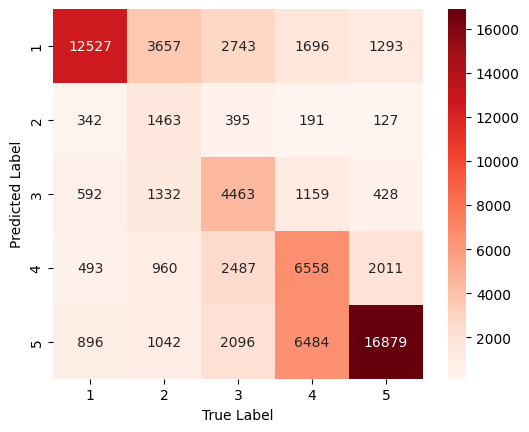

Accuracy: 0.5792792543629173
F1-score: 0.5101788424613803
Precision: 0.5705308201100999
Recall: 0.5208945529973461

Classification performance:
               precision    recall  f1-score   support

           1       0.57      0.84      0.68     14850
           2       0.58      0.17      0.27      8454
           3       0.56      0.37      0.44     12184
           4       0.52      0.41      0.46     16088
           5       0.62      0.81      0.70     20738

    accuracy                           0.58     72314
   macro avg       0.57      0.52      0.51     72314
weighted avg       0.57      0.58      0.55     72314



In [19]:
# Get metrics

get_metrics(scores_test, NB_prediction)

# KNN model

In [22]:
# Compute GloVe embeddings dictionary

embeddings_dict = {}

with open('glove.6B.50d.txt', 'r', encoding='utf-8') as f: #Replace with 100d, 200d or 300d
    
    for line in f:
        
        values = line.split()
        
        word = values[0]
        
        vector  = np.asarray(values[1:], dtype = float)
        
        embeddings_dict[word] = vector
        
# Check for any bad keys which don't have 50 dimensions in the Glove embeddings

bad_keys = []

for key in embeddings_dict.keys():
    
    if embeddings_dict[key].shape[0] != 50:       
        print(key)
        
        bad_keys.append(key)

print(bad_keys)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:1007)>

In [ ]:
# Define document embedding function

def get_document_embedding(word_list, word_embeddings, k):
    
    document_embedding = np.zeros(k, dtype = float) # Create embedding of k zero-valued elements
    
    valid_words = 0
    
    for word in word_list:
        
        try:
            document_embedding = document_embedding + word_embeddings[word]
            
            valid_words += 1
        
        except:
            
            pass # If word embedding is not available, then ignore the word
        
    if valid_words > 0:
        
        document_embedding = document_embedding / valid_words
    
    else: 
        
        document_embedding = np.zeros(k, dtype = float) # In case valid words = 0
    
    return document_embedding

In [ ]:
# Document embeddings for samples_train

samples_train_embeddings = [] # List to store document embeddings of training data

for i in range(len(samples_train)):
    
    train_tokens = word_tokenize(samples_train[i]) # Tokenize each review in the training dataset
            
    samples_train_embeddings.append(get_document_embedding(train_tokens, embeddings_dict, 50))
    

# Document embeddings for samples_test

samples_test_embeddings = []
    
for i in range(len(samples_test)):
    
    test_tokens = word_tokenize(samples_test[i]) # Tokenize each review in the testing set
            
    samples_test_embeddings.append(get_document_embedding(test_tokens, embeddings_dict, 50))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Define value for k

neighbor = [1,3,5,7]

# Create a dictionary to store k values and their corresponding cross-validation accuracy

cv_score = {}

# Iterate over k

for k in neighbor:
    
    model = KNeighborsClassifier(n_neighbors = k)
    
    # Get model accuracy using Cross-validation
    cross_val = cross_val_score(model, samples_train_embeddings, scores_train, cv = 10, scoring = 'accuracy')
    
    cv_score[k] = cross_val.mean() # Add the average cross-validation accuracy to the dictionary

In [ ]:
# Plot k and classification performance

import matplotlib.pyplot as plt

plt.plot(neighbor, cv_score.values())

plt.xlabel('Number of Neighbors k')

plt.ylabel('Cross-Validation Accuracy')

plt.title('k vs. Classification Performance')

plt.show()

In [ ]:
# Find the best k with highest accuracy

best_k = max(cv_score, key = cv_score.get)

# Train the final model using the best k value

KNN_model = KNeighborsClassifier(n_neighbors = best_k)

# Fit the model using training data
KNN_model.fit(samples_train_embeddings, scores_train)

# Predict on the testing data
KNN_prediction = KNN_model.predict(samples_test_embeddings)

print("Predicted:",KNN_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",scores_test[0:10]) # Print the first 10 ground truth values

In [ ]:
# Get metrics

get_metrics(scores_test, KNN_prediction)

# Convolutional Neural Network (CNN)

In [23]:
# Turn training set and testing set into numpy array
import numpy as np

X_train = np.array(samples_train)
Y_train = np.array(scores_train) - 1 # NumPy array indexing at 0
X_test = np.array(samples_test)

In [24]:
# Turn training set and testing set into numpy array
import numpy as np

X_train = np.array(samples_train)
Y_train = np.array(scores_train) - 1 # NumPy array indexing at 0
X_test = np.array(samples_test)

from tensorflow.keras.layers import TextVectorization

# The maximum number of words to be used (most frequent words in the dataset)
max_vocabulary = 20000

# Number of words in each text. All sequences will be padded or truncated to this length.
max_sequence_length = 200

# Create a preprocessing layer which maps text features to integer sequences
vectorize_layer = TextVectorization(max_tokens = max_vocabulary,
                                    output_mode = 'int', # Represent each word in the vocabulary with an integer
                                    output_sequence_length = max_sequence_length)

# Computes a vocabulary of string terms from tokens in a dataset
vectorize_layer.adapt(X_train)

# Check vocabulary length
print("Vocabulary size: " + str(len(vectorize_layer.get_vocabulary())) + " words")

Vocabulary size: 20000 words


In [45]:
# Define CNN architecture

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten

embedding_dim = 20 # Size of the word embedding to be used

CNN_model = Sequential(name='MyCNN')

CNN_model.add(vectorize_layer)

# Add Embedding layer

CNN_model.add(Embedding(input_dim=max_vocabulary,
                        output_dim=embedding_dim,
                        input_shape=(max_sequence_length,)))  # Size of the word embedding


CNN_model.add(Flatten())

# First Conv1D layer
CNN_model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))

# Add Dropout layer
CNN_model.add(Dropout(0.2))

# Second Conv1D layer
CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

# Another Dropout layer
CNN_model.add(Dropout(0.2))

# GlobalMaxPooling1D to reduce the dimensions for the Dense layer
CNN_model.add(GlobalMaxPooling1D())

# Output layer which output probability for each class
CNN_model.add(Dense(5, activation='softmax'))

CNN_model.summary()

Model: "MyCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_17 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_14         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Define hyperparameters

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

epochs = 20
batch_size = 1000
learning_rate = 0.01

opt = Adam(learning_rate = learning_rate) # Initialise Adam optimiser with a leanring rate of 0.01
CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # Initialise model

# Define early stopping that will stop after 4 epochs if there is no improvement to the accuracy
early_1 = EarlyStopping(monitor = 'val_accuracy', patience = 4, 
                     restore_best_weights = True, mode = 'auto')

# Fit the model
CNN_model_fit = CNN_model.fit(X_train, Y_train,
                   epochs = epochs, batch_size = batch_size, 
                   validation_split = 0.2, # Use 20% of training data as validation data
                   callbacks = [early_1])

ValueError: Invalid dtype: str445472

In [ ]:
# Predict on the testing data

CNN_prediction = CNN_model.predict(X_test)

# Return the indices of the maximum values along the row and plus 1 to adjust the indices as the trained labels start from 0 to 4

CNN_class_prediction = np.argmax(CNN_prediction, axis = -1) + 1

print("Predicted:",CNN_class_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",scores_test[0:10]) # Print the first 10 ground truth values

In [ ]:
# Get metrics

get_metrics(scores_test, CNN_class_prediction)

# Long Short-Term Memory (LSTM) model

In [ ]:
# Turn training set and testing set into numpy array
import numpy as np

X_train = np.array(samples_train)
Y_train = np.array(scores_train) - 1 # NumPy array indexing at 0
X_test = np.array(samples_test)

In [ ]:
from tensorflow.keras.layers import TextVectorization

# The maximum number of words to be used (most frequent words in the dataset)
max_vocabulary = 20000

# Number of words in each text. All sequences will be padded or truncated to this length.
max_sequence_length = 200

# Create a preprocessing layer which maps text features to integer sequences
vectorize_layer = TextVectorization(max_tokens = max_vocabulary,
                                    output_mode = 'int', # Represent each word in the vocabulary with an integer
                                    output_sequence_length = max_sequence_length)

# Computes a vocabulary of string terms from tokens in a dataset
vectorize_layer.adapt(X_train)

# Check vocabulary length
print("Vocabulary size: " + str(len(vectorize_layer.get_vocabulary())) + " words")

In [ ]:
# Define model architecture 

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Bidirectional, LSTM

embedding_dim = 20 # Size of the word embedding to be used

LSTM_model = Sequential(name = 'MyLSTM')

LSTM_model.add(Input(shape = (1,), dtype = tf.string))

LSTM_model.add(vectorize_layer)

# Add Embedding layer
LSTM_model.add(Embedding(input_dim = max_vocabulary, # Size of the vocabulary
                   output_dim = embedding_dim, # Size of the word embedding
                    input_length = max_sequence_length)) #length of input sequences

# First BiDirectional LSTM layer. Set return_sequences=True for additional LSTM layer
LSTM_model.add(Bidirectional(LSTM(16, return_sequences = True)))

# Second BiDirectional LSTM layer with Dropout
LSTM_model.add(Bidirectional(LSTM(16, go_backwards=True, dropout=0.2)))

# Output layer which output probability for each class
LSTM_model.add(Dense(5, activation = 'softmax'))

LSTM_model.summary()

In [ ]:
# Define hyperparameters

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

epochs = 20
batch_size = 1000
learning_rate = 0.01

opt = Adam(learning_rate = learning_rate) # Initialise Adam optimiser with a leanring rate of 0.01

LSTM_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # Initialise model

# Define early stopping that will stop after 4 epochs if there is no improvement to the accuracy
early_2 = EarlyStopping(monitor = 'val_accuracy', patience = 4, 
                     restore_best_weights = True, mode = 'auto')

# Fit the model
LSTM_model_fit = LSTM_model.fit(X_train, Y_train,
                   epochs = epochs, batch_size = batch_size, 
                   validation_split = 0.2, 
                   callbacks = [early_2])

In [ ]:
# Predict on the testing data
LSTM_prediction = LSTM_model.predict(X_test)

# Return the indices of the maximum values along the row and plus 1 to adjust the indices as the trained labels start from 0 to 4
LSTM_class_prediction = np.argmax(LSTM_prediction, axis=-1) + 1

print("Predicted:",LSTM_class_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",scores_test[0:10]) # Print the first 10 ground truth values

In [ ]:
# Get metrics

get_metrics(scores_test, LSTM_class_prediction)